<a href="https://colab.research.google.com/github/adenurchalisa/Capstone-Model/blob/main/model_prediksi_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# 1. Mount Google Drive (jika di Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/capstoneku/data_transaksi_advanced.csv'
df = pd.read_csv(file_path)
df['tanggal'] = pd.to_datetime(df['tanggal'])

In [4]:
# 2. PREPROCESSING DASAR
df = df.drop(columns=['rating', 'anomaly_flag', 'id_transaksi'])
df['bulan'] = df['tanggal'].dt.month
df['tahun'] = df['tanggal'].dt.year
df = df.drop(columns=['tanggal', 'waktu'])

In [5]:
# 3. FITUR MUSIMAN (LEBIH SEDERHANA)
df['is_ramadan'] = (
    ((df['tahun'] == 2022) & (df['bulan'] == 4)) |
    ((df['tahun'] == 2023) & (df['bulan'].isin([3, 4]))) |
    ((df['tahun'] == 2024) & (df['bulan'].isin([3, 4])))
).astype(int)

df['is_lebaran'] = (
    ((df['tahun'] == 2022) & (df['bulan'] == 5)) |
    ((df['tahun'] == 2023) & (df['bulan'] == 4)) |
    ((df['tahun'] == 2024) & (df['bulan'] == 4))
).astype(int)

df['is_akhir_tahun'] = (df['bulan'] == 12).astype(int)

In [6]:
# 4. FILTER DATA PENGELUARAN
df_pengeluaran = df[df['tipe'] == 'keluar'].copy()

In [7]:
# 5. AGREGASI BULANAN YANG LEBIH SEDERHANA
agg = df_pengeluaran.groupby(['user_id', 'tahun', 'bulan']).agg(
    total_pengeluaran=('nominal', 'sum'),
    jumlah_transaksi=('nominal', 'count')
).reset_index()
agg = agg.sort_values(['user_id', 'tahun', 'bulan'])

In [8]:
# 6. FITUR TIME-SERIES LEBIH SEDERHANA
# Hanya menggunakan lag-1 (bulan lalu) dan rolling-3
agg['pengeluaran_bulan_lalu'] = agg.groupby('user_id')['total_pengeluaran'].shift(1)
agg['rolling3_pengeluaran'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).mean().shift(1).values
agg['target'] = agg.groupby('user_id')['total_pengeluaran'].shift(-1)

In [9]:
# 7. TAMBAH FITUR MUSIMAN KE DATA AGREGASI
agg['is_ramadan'] = (
    ((agg['tahun'] == 2022) & (agg['bulan'] == 4)) |
    ((agg['tahun'] == 2023) & (agg['bulan'].isin([3, 4]))) |
    ((agg['tahun'] == 2024) & (agg['bulan'].isin([3, 4])))
).astype(int)
agg['is_lebaran'] = (
    ((agg['tahun'] == 2022) & (agg['bulan'] == 5)) |
    ((agg['tahun'] == 2023) & (agg['bulan'] == 4)) |
    ((agg['tahun'] == 2024) & (agg['bulan'] == 4))
).astype(int)
agg['is_akhir_tahun'] = (agg['bulan'] == 12).astype(int)

In [10]:
# 8. DROP NA DAN SPLIT DATA
agg = agg.dropna(subset=['target', 'pengeluaran_bulan_lalu']).reset_index(drop=True)
train = agg[agg['tahun'] < 2024]
test = agg[agg['tahun'] == 2024]

In [11]:
# 9. PILIH FITUR YANG LEBIH SEDERHANA
fitur = [
    'pengeluaran_bulan_lalu',
    'rolling3_pengeluaran',
    'bulan',
    'is_ramadan',
    'is_lebaran',
    'is_akhir_tahun'
]
X_train = train[fitur]
y_train = train['target']
X_test = test[fitur]
y_test = test['target']

In [12]:
# 10. LOG TRANSFORM TARGET
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# 11. TRAIN MODEL XGBOOST DENGAN PARAMETER SEDERHANA
model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)
model.fit(X_train, y_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [13]:
# 12. EVALUASI MODEL
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 6868809.13
RMSE: 10591207.68
MAPE: 531.16%


In [14]:
# 13. ANALISIS FEATURE IMPORTANCE
importance = pd.DataFrame({
    'feature': fitur,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(importance)


Feature Importance:
                  feature  importance
1    rolling3_pengeluaran    0.345229
2                   bulan    0.214403
0  pengeluaran_bulan_lalu    0.192768
3              is_ramadan    0.135455
4              is_lebaran    0.112144
5          is_akhir_tahun    0.000000


<Figure size 1000x500 with 0 Axes>

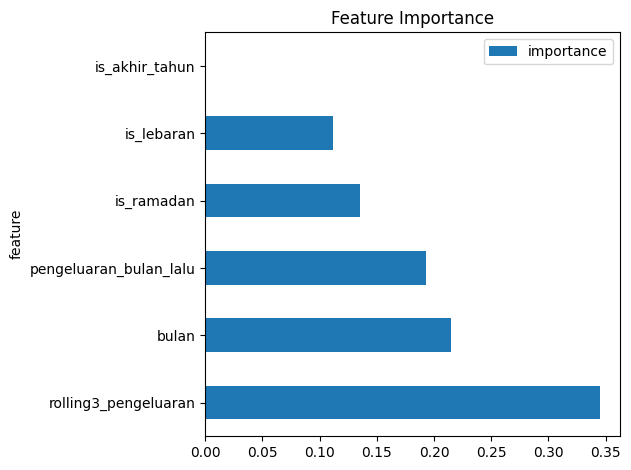

In [15]:
# 14. VISUALISASI FEATURE IMPORTANCE
plt.figure(figsize=(10, 5))
importance.plot(kind='barh', x='feature', y='importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

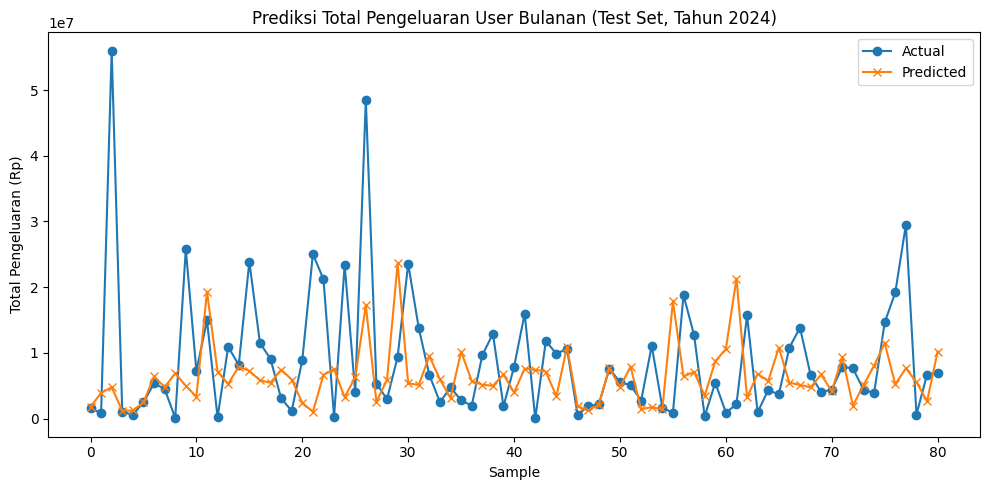

In [16]:
# 15. VISUALISASI PREDIKSI VS AKTUAL
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.legend()
plt.title('Prediksi Total Pengeluaran User Bulanan (Test Set, Tahun 2024)')
plt.xlabel('Sample')
plt.ylabel('Total Pengeluaran (Rp)')
plt.tight_layout()
plt.show()

In [17]:
# 16. BASELINE COMPARISON (NAIVE FORECAST)
baseline_pred = X_test['pengeluaran_bulan_lalu']
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_mape = np.mean(np.abs((y_test - baseline_pred) / y_test)) * 100
print(f"\nBaseline MAE: {baseline_mae:.2f}")
print(f"Baseline MAPE: {baseline_mape:.2f}%")


Baseline MAE: 8093284.09
Baseline MAPE: 674.36%


In [18]:
# 17. ANALISIS ERROR PER USER
df_eval = test[['user_id', 'bulan', 'tahun']].copy()
df_eval["actual"] = y_test.values
df_eval["pred"] = y_pred
df_eval["abs_error"] = abs(df_eval["actual"] - df_eval["pred"])
df_eval["mape"] = 100 * abs(df_eval["actual"] - df_eval["pred"]) / (df_eval["actual"] + 1e-8)
user_error = df_eval.groupby("user_id")["mape"].mean().sort_values(ascending=False)
print("\n10 User dengan MAPE tertinggi:")
print(user_error.head(10))


10 User dengan MAPE tertinggi:
user_id
U013    4774.677986
U003    2137.832245
U004     970.629047
U007     716.450683
U017     527.592763
U019     517.650417
U018     340.855805
U025     303.508315
U020     276.603557
U006     158.145007
Name: mape, dtype: float64


In [19]:
# 18. EXCLUDE USER OUTLIER (OPSIONAL)
threshold = 500
outlier_users = user_error[user_error > threshold].index.tolist()
print(f"\nUser outlier (MAPE > {threshold}%): {outlier_users}")


User outlier (MAPE > 500%): ['U013', 'U003', 'U004', 'U007', 'U017', 'U019']



Hasil tanpa user outlier:
MAE: 6584331.09
RMSE: 10959260.32
MAPE: 144.09%


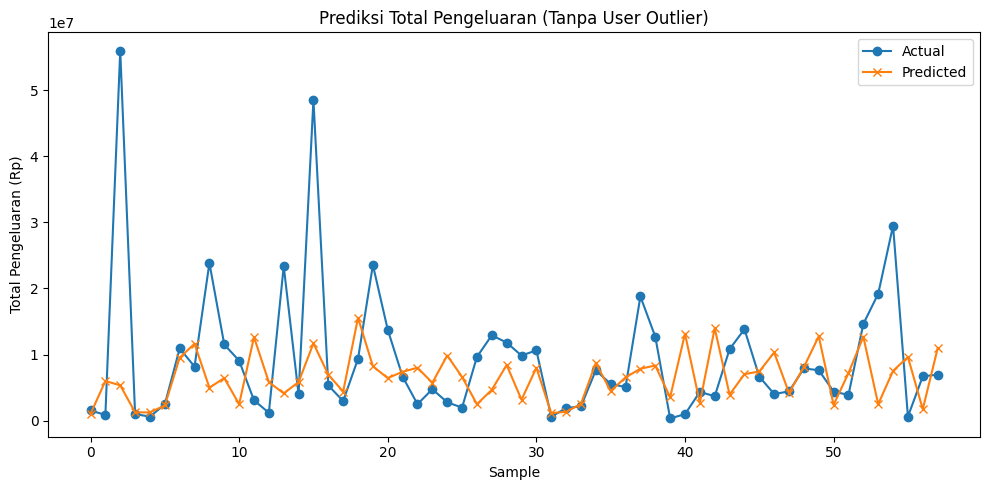

In [20]:
# 19. EVALUASI TANPA USER OUTLIER (OPSIONAL)
if outlier_users:
    train_clean = train[~train['user_id'].isin(outlier_users)].copy()
    test_clean = test[~test['user_id'].isin(outlier_users)].copy()
    X_train_clean = train_clean[fitur]
    y_train_clean = train_clean['target']
    X_test_clean = test_clean[fitur]
    y_test_clean = test_clean['target']

    y_train_clean_log = np.log1p(y_train_clean)
    model_clean = XGBRegressor(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        random_state=42
    )
    model_clean.fit(X_train_clean, y_train_clean_log)

    y_pred_clean_log = model_clean.predict(X_test_clean)
    y_pred_clean = np.expm1(y_pred_clean_log)
    mae_clean = mean_absolute_error(y_test_clean, y_pred_clean)
    rmse_clean = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
    mape_clean = np.mean(np.abs((y_test_clean - y_pred_clean) / y_test_clean)) * 100
    print(f"\nHasil tanpa user outlier:")
    print(f"MAE: {mae_clean:.2f}")
    print(f"RMSE: {rmse_clean:.2f}")
    print(f"MAPE: {mape_clean:.2f}%")

    # Visualisasi tanpa outlier
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_clean.values, label='Actual', marker='o')
    plt.plot(y_pred_clean, label='Predicted', marker='x')
    plt.legend()
    plt.title('Prediksi Total Pengeluaran (Tanpa User Outlier)')
    plt.xlabel('Sample')
    plt.ylabel('Total Pengeluaran (Rp)')
    plt.tight_layout()
    plt.show()

In [23]:
# 20. CONTOH PREDIKSI DATA BARU (1 BULAN KE DEPAN) - DIPERBAIKI
print("\nContoh Prediksi untuk Bulan Berikutnya:")

# Dapatkan data bulan terakhir setiap user
latest_data = test.sort_values(['user_id', 'tahun', 'bulan']).groupby('user_id').last().reset_index()

# Buat DataFrame untuk prediksi bulan berikutnya
next_month_data = []
for _, row in latest_data.iterrows():
    user_id = row['user_id']
    current_month = row['bulan']
    current_year = row['tahun']

    # Tentukan bulan dan tahun berikutnya
    next_month = current_month % 12 + 1
    next_year = current_year + 1 if next_month == 1 else current_year

    # Isi fitur untuk bulan berikutnya
    next_data = {
        'user_id': user_id,
        'bulan': next_month,
        'tahun': next_year,
        'pengeluaran_bulan_lalu': row['total_pengeluaran'],
        'rolling3_pengeluaran': row['rolling3_pengeluaran'],  # Menggunakan nilai sebelumnya, idealnya diupdate
        'is_ramadan': 1 if (next_year == 2024 and next_month in [3, 4]) else 0,
        'is_lebaran': 1 if (next_year == 2024 and next_month == 4) else 0,
        'is_akhir_tahun': 1 if next_month == 12 else 0
    }
    next_month_data.append(next_data)

# Buat DataFrame untuk prediksi
X_next = pd.DataFrame(next_month_data)
print(f"Data untuk prediksi bulan berikutnya:")
print(X_next[['user_id', 'bulan', 'tahun', 'pengeluaran_bulan_lalu']].head())

# Prediksi bulan berikutnya
y_next_log = model.predict(X_next[fitur])
y_next = np.expm1(y_next_log)

# Tampilkan prediksi
result = pd.DataFrame({
    'user_id': X_next['user_id'],
    'bulan_prediksi': X_next['bulan'],
    'tahun_prediksi': X_next['tahun'],
    'prediksi_pengeluaran': y_next
})
print("\nHasil prediksi pengeluaran bulan berikutnya:")
print(result.head(10))


Contoh Prediksi untuk Bulan Berikutnya:
Data untuk prediksi bulan berikutnya:
  user_id  bulan  tahun  pengeluaran_bulan_lalu
0    U001      4   2024            8.540148e+05
1    U002      4   2024            5.997162e+05
2    U003      4   2024            4.510504e+06
3    U004      5   2024            1.493738e+07
4    U005      4   2024            8.179870e+06

Hasil prediksi pengeluaran bulan berikutnya:
  user_id  bulan_prediksi  tahun_prediksi  prediksi_pengeluaran
0    U001               4            2024            3227805.25
1    U002               4            2024            2320738.25
2    U003               4            2024            6028960.50
3    U004               5            2024           17559012.00
4    U005               4            2024            5713001.00
5    U006               5            2024            6022564.50
6    U007               5            2024           12341660.00
7    U008               4            2024            8152198.50
8    U009  